# Forex predictions using Machine Learning
# Loading and preparing data

In [1]:
import pandas as pd
df = pd.read_csv("/Users/veddarji0108/Downloads/CODING/USDJPY_Candlestick_1_D_ASK_05.05.2003-19.10.2019.csv")
df.tail()

,Local time,open,high,low,close,volume
4323,14.10.2019 00:00:00.000 GMT+0300,108.372,108.525,108.033,108.404,122267.0400
4324,15.10.2019 00:00:00.000 GMT+0300,108.408,108.901,108.157,108.868,161800.8200
4325,16.10.2019 00:00:00.000 GMT+0300,108.878,108.878,108.565,108.792,178244.1800
4326,17.10.2019 00:00:00.000 GMT+0300,108.793,108.941,108.454,108.692,234278.7681
4327,18.10.2019 00:00:00.000 GMT+0300,108.706,108.724,108.388,108.433,148743.3600


In [2]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

Local time    0
open          0
high          0
low           0
close         0
volume        0
dtype: int64

In [5]:
pip install pandas_ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=bf855b4279f3d67aa7e315dafc85cec81d1fd96787117683091cf4d33d36912b
  Stored in directory: /Users/veddarji0108/Library/Caches/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [7]:
df.tail()

,Local time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
4323,14.10.2019 00:00:00.000 GMT+0300,108.372,108.525,108.033,108.404,122267.0400,0.677267,61.010164,108.2790,107.236900,107.399175,108.878912,0.040158,0.003133,-0.021597,0.276314,3.246695
4324,15.10.2019 00:00:00.000 GMT+0300,108.408,108.901,108.157,108.868,161800.8200,0.680604,65.223022,108.5290,107.302650,107.419962,108.859969,0.048853,0.010529,-0.021116,0.305829,3.651563
4325,16.10.2019 00:00:00.000 GMT+0300,108.878,108.878,108.565,108.792,178244.1800,0.662224,64.003170,108.7215,107.356525,107.432337,108.841300,0.052381,0.014445,-0.020423,0.292314,2.470620
4326,17.10.2019 00:00:00.000 GMT+0300,108.793,108.941,108.454,108.692,234278.7681,0.653462,62.350755,108.6975,107.412275,107.443287,108.823081,0.054542,0.014847,-0.019662,0.215143,1.069447
4327,18.10.2019 00:00:00.000 GMT+0300,108.706,108.724,108.388,108.433,148743.3600,0.637589,58.162392,108.5560,107.486275,107.449425,108.805869,0.058493,0.013281,-0.018739,0.086300,-0.379915


# Target categories

In [8]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [9]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Local time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,05.05.2003 00:00:00.000 GMT+0300,118.990,119.070,118.471,118.653,563551.1134,NaN,NaN,118.7705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,06.05.2003 00:00:00.000 GMT+0300,118.641,118.771,117.300,117.550,567318.3077,NaN,NaN,118.0355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,07.05.2003 00:00:00.000 GMT+0300,117.506,117.848,116.062,116.353,562770.3985,NaN,NaN,116.9550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,08.05.2003 00:00:00.000 GMT+0300,116.361,116.979,115.950,116.873,565066.5899,NaN,NaN,116.4645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,09.05.2003 00:00:00.000 GMT+0300,116.855,117.626,116.810,117.201,565239.7001,NaN,NaN,117.2180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# Quick analysis example

/var/folders/44/5fjpmy5x6kg9yc3gslmc0bww0000gn/T/ipykernel_22740/2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


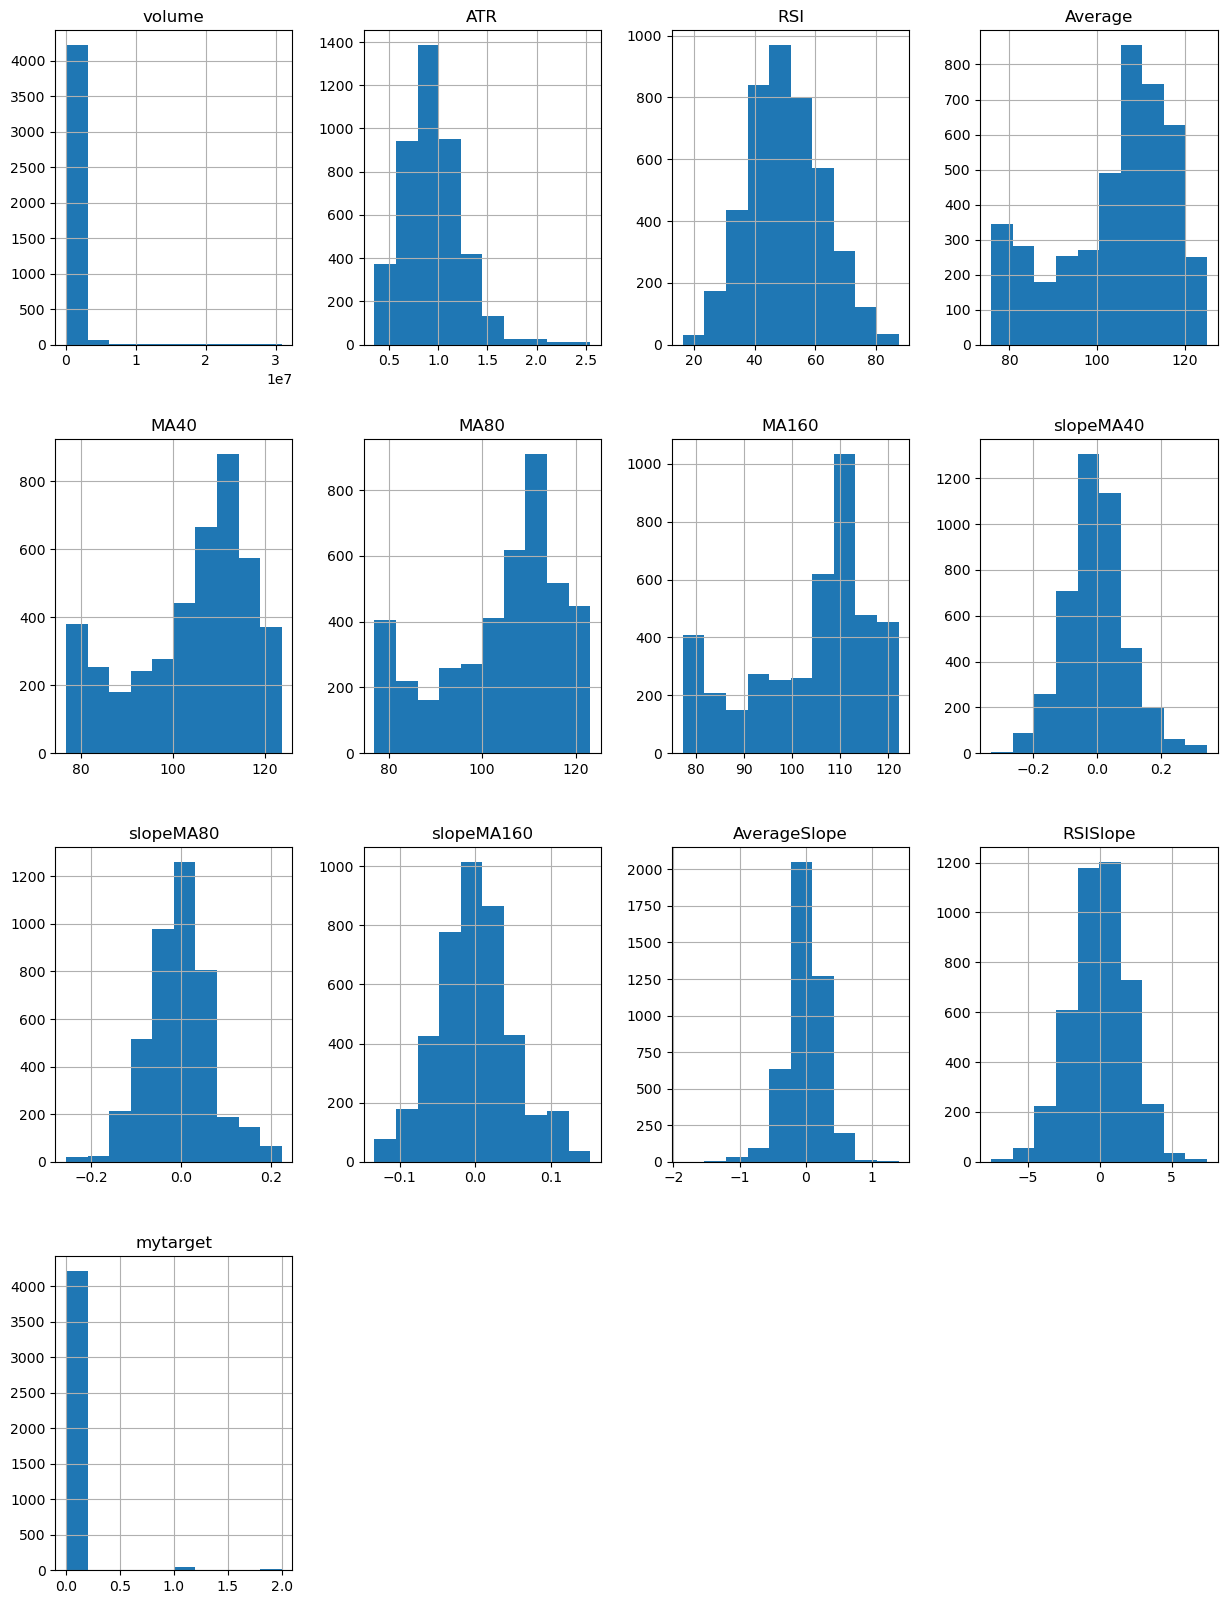

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

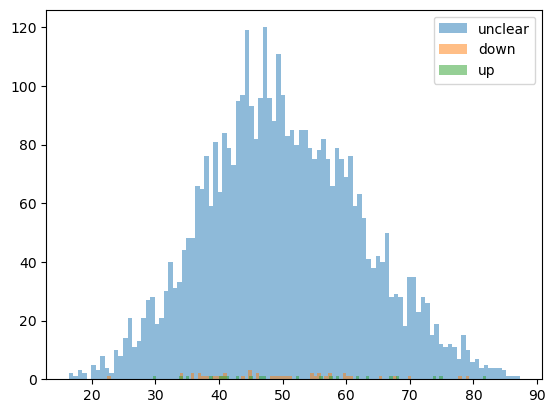

In [11]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [12]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

           ATR        RSI   Average        MA40        MA80       MA160  \
165   0.866351  44.506557  107.7545  108.644625  110.622938  114.448812   
166   0.856181  42.120858  107.6075  108.620350  110.510388  114.389194   
167   0.831467  41.066281  107.4120  108.598625  110.395788  114.331719   
168   0.812740  39.499557  107.3295  108.571600  110.287700  114.275637   
169   0.788549  39.390453  107.2265  108.533525  110.168812  114.217262   
...        ...        ...       ...         ...         ...         ...   
4305  0.649515  65.885506  108.2840  106.927625  107.540050  109.230675   
4306  0.651290  59.590946  108.1325  106.912925  107.520325  109.219606   
4307  0.646625  53.236671  107.8110  106.885100  107.511500  109.205963   
4308  0.637294  52.914147  107.5410  106.854200  107.504913  109.188238   
4309  0.647279  47.253783  107.3805  106.815950  107.491712  109.166962   

      slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
165   -0.047606  -0.121743   -0.06

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [15]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 98.51%
Accuracy test: 98.18%
mytarget
0.0    98.444714
1.0     1.020656
2.0     0.534629
Name: count, dtype: float64
Accuracy Gambler: 32.20%


In [17]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.0 MB/s eta 0:00:000:00:01:010m
Note: you may need to restart the kernel to use updated packages.


## More powerful model XGBoost

In [18]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 97.9344%


## !!Data sampling shouldn't be random

In [19]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 97.8129%


## Which features are most important for our model?

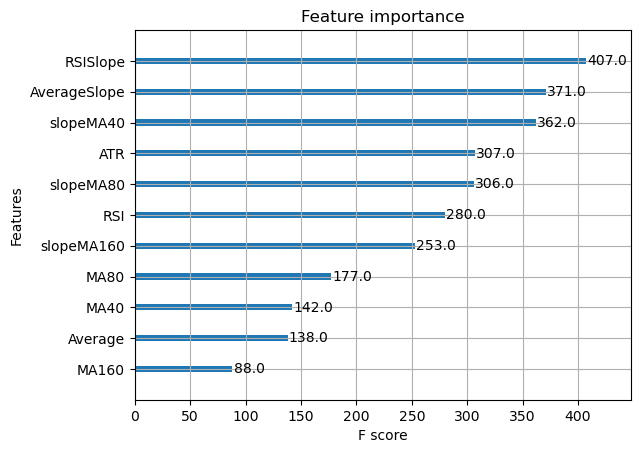

In [20]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [21]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

In [31]:
# pip install apscheduler 

# !pip install oandapyV20

!pip install oanda_candles

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 300.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 687.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for oandapyV20: filename=oandapyV20-0.6.3-py3-none-any.whl size=69502 sha256=c449b13368edb86f99ab52697b61b0aea6d1740b79fb75fa39d57f775024c57f
  Stored in directory: /Users/veddarji0108/Library/Caches/pip/wheels/61/d4/d8/4015cf7ce78243321d426e163feb6d4b6445a464174f3d6921
Successfully built oandapyV20
  Attempting uninstall: oandapyV20
    Found existing installation: oandapyV20 0.7.2
    Uninstalling oandapyV20-0.7.2:
      Successfully uninstalled oandapyV20-0.7.2
  Attempting uninstall: pluggy
    Found existing installation: pluggy 1.0.0
    Uninstalling pluggy-1.0.0:
      Successfully uninstalled pluggy-1.0.0
  Attempting uninstall: pytest
    Found existing insta

## Live Automated Orders with email notification

In [32]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [33]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [34]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()